In [1]:
# Add Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
# Create path to data files
mouse_metadata_path = "raw_data/mouse_metadata.csv"
study_results_path = "raw_data/study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [3]:
# Preview mouse_metadata
mouse_metadata.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [4]:
# Preview study_results
study_results.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [5]:
# Combine the data into a single dataset
capomulin_study_data = pd.merge(mouse_metadata, study_results, on="Mouse ID")
capomulin_study_data.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [7]:
# Ensure capomulin_study_data is a clean dataset by checking for duplicate Timepoint values for each Mouse ID
duplicate_timepoints = capomulin_study_data[capomulin_study_data.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

if not duplicate_timepoints.empty:
    print("Duplicate Timepoints found in capomulin_study_data")
    print(duplicate_timepoints)
else:
    print("No duplicate Timepoints found in capomulin_study_data")

Duplicate Timepoints found in capomulin_study_data
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
908           45.000000                 0  
909           45.000000                 0  
910           48.786801 

In [15]:
# Group duplicate_timepoints by Mouse ID and Timepoint taking the mean of the duplicate Tumor Volume (mm3) and Metastatic Sites values
group_duplicate_timepoints = duplicate_timepoints.groupby(["Mouse ID", "Timepoint"]).agg({"Tumor Volume (mm3)": "mean", "Metastatic Sites": "mean"}).reset_index()
print(group_duplicate_timepoints)

  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0           45.000000               0.0
1     g989          5           48.178597               0.0
2     g989         10           50.812842               0.0
3     g989         15           52.383936               0.5
4     g989         20           54.991886               1.0


In [21]:
# Mupltiply the Tumor Volume (mm3) and Metastatic Sites values by -1 in group_duplicate_timepoints
group_duplicate_timepoints["Tumor Volume (mm3)"] = group_duplicate_timepoints["Tumor Volume (mm3)"] * -1
group_duplicate_timepoints["Metastatic Sites"] = group_duplicate_timepoints["Metastatic Sites"] * -1
print(group_duplicate_timepoints)

  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0          -45.000000              -0.0
1     g989          5          -48.178597              -0.0
2     g989         10          -50.812842              -0.0
3     g989         15          -52.383936              -0.5
4     g989         20          -54.991886              -1.0


In [20]:
# Compare the group_duplicate_timepoints data with the fist instance of each Mouse ID and Timepoint in duplicate_timepoints
first_instance = duplicate_timepoints.drop_duplicates(subset=["Mouse ID", "Timepoint"], keep="first").drop(columns=["Drug Regimen", "Sex", "Age_months", "Weight (g)"])
print(first_instance)


    Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
908     g989          0           45.000000                 0
910     g989          5           48.786801                 0
912     g989         10           51.745156                 0
914     g989         15           51.325852                 1
916     g989         20           55.326122                 1


In [22]:
# Merge the first_instance data with the group_duplicate_timepoints data using the Mouse ID and Timepoint columns and sum the Tumor Volume (mm3) and Metastatic Sites values
duplicate_test = pd.merge(first_instance, group_duplicate_timepoints, on=["Mouse ID", "Timepoint"], suffixes=("_first", "_mean"))
duplicate_test["Tumor Volume (mm3)"] = duplicate_test["Tumor Volume (mm3)_first"] + duplicate_test["Tumor Volume (mm3)_mean"]
duplicate_test["Metastatic Sites"] = duplicate_test["Metastatic Sites_first"] + duplicate_test["Metastatic Sites_mean"]
duplicate_test = duplicate_test.drop(columns=["Tumor Volume (mm3)_first", "Metastatic Sites_first", "Tumor Volume (mm3)_mean", "Metastatic Sites_mean"])
print(duplicate_test)


  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     g989          0            0.000000               0.0
1     g989          5            0.608205               0.0
2     g989         10            0.932314               0.0
3     g989         15           -1.058084               0.5
4     g989         20            0.334236               0.0


In [23]:
# Display any Mouse ID in which the Tumor Volume (mm3) or Metastatic Sites values are not equal to 0
duplicate_test = duplicate_test[(duplicate_test["Tumor Volume (mm3)"] != 0) | (duplicate_test["Metastatic Sites"] != 0)]
print(duplicate_test)


  Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
1     g989          5            0.608205               0.0
2     g989         10            0.932314               0.0
3     g989         15           -1.058084               0.5
4     g989         20            0.334236               0.0


In [24]:
# List unique Mouse ID values in duplicate_test
duplicate_mice = duplicate_test["Mouse ID"].unique()
print(duplicate_mice)

['g989']


In [25]:
# Drop the Mouse ID values in duplicate_mice from capomulin_study_data and reset the index
capomulin_study_data_clean = capomulin_study_data[~capomulin_study_data["Mouse ID"].isin(duplicate_mice)].reset_index(drop=True)
capomulin_study_data_clean.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [ ]:
# If there were duplicate enetries that were double entries (All data was equal for every double entry) in the capomulin_study_data dataset. This is where I would drop the duplicates and keep the first entry.

In [26]:
# Ensure capomulin_study_data_clean is a clean dataset by checking for duplicate Timepoint values for each Mouse ID again
duplicate_timepoints_2 = capomulin_study_data_clean[capomulin_study_data_clean.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

if not duplicate_timepoints_2.empty:
    print("Duplicate Timepoints found in capomulin_study_data_clean")
    print(duplicate_timepoints_2)
else:
    print("No duplicate Timepoints found in capomulin_study_data_clean")

No duplicate Timepoints found in capomulin_study_data_clean


In [27]:
# Save the cleaned dataset to a new CSV file
import os
cleaned_data_path = os.path.join("cleaned_data", "capomulin_study_data_clean.csv")
capomulin_study_data_clean.to_csv(cleaned_data_path, index=False)
print(f"Cleaned data saved to {cleaned_data_path}")


Cleaned data saved to cleaned_data\capomulin_study_data_clean.csv


In [38]:
# Delete tumor_volume_change DataFrame and set it to None
tumor_volume_change = None

In [39]:
# Create a copy of capomulin_study_data_clean DataFrame and add "Tumor Volume (mm3) Change" column to it
csdc_tumor_volume_change = capomulin_study_data_clean.copy()
csdc_tumor_volume_change["Tumor Volume (mm3) Change"] = 0.0
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,0.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,0.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,0.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,0.0


In [40]:
# Set the initial Tumor Volume (mm3) for each Mouse ID
initial_tumor_volume = csdc_tumor_volume_change.groupby("Mouse ID").first().reset_index()
initial_tumor_volume = initial_tumor_volume[["Mouse ID", "Tumor Volume (mm3)"]]
initial_tumor_volume = initial_tumor_volume.rename(columns={"Tumor Volume (mm3)": "Initial Tumor Volume (mm3)"})
initial_tumor_volume.head()

,Mouse ID,Initial Tumor Volume (mm3)
0,a203,45.0
1,a251,45.0
2,a262,45.0
3,a275,45.0
4,a366,45.0


In [41]:
# Use the initial_tumor_volume DataFrame to set the "Initial Tumor Volume (mm3)" for each Mouse ID in the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change = pd.merge(csdc_tumor_volume_change, initial_tumor_volume, on="Mouse ID")
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3)
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.0,45.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,0.0,45.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,0.0,45.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,0.0,45.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,0.0,45.0


In [42]:
# Calculate the "Tumor Volume (mm3) Change" for each Mouse ID in the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change["Tumor Volume (mm3) Change"] = csdc_tumor_volume_change["Initial Tumor Volume (mm3)"] - csdc_tumor_volume_change["Tumor Volume (mm3)"]
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3)
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0
1,k403,Ramicane,Male,21,16,5,38.825898,0,6.174102,45.0
2,k403,Ramicane,Male,21,16,10,35.014271,1,9.985729,45.0
3,k403,Ramicane,Male,21,16,15,34.223992,1,10.776008,45.0
4,k403,Ramicane,Male,21,16,20,32.997729,1,12.002271,45.0


In [46]:
# Add a ["% Size Reduction"] column to the csdc_tumor_volume_change DataFrame
csdc_tumor_volume_change["Tumor Volume % Reduction"] = (csdc_tumor_volume_change["Tumor Volume (mm3) Change"] / csdc_tumor_volume_change["Initial Tumor Volume (mm3)"]) * 100
csdc_tumor_volume_change.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Tumor Volume (mm3) Change,Initial Tumor Volume (mm3),Tumor Volume % Reduction
0,k403,Ramicane,Male,21,16,0,45.000000,0,0.000000,45.0,0.000000
1,k403,Ramicane,Male,21,16,5,38.825898,0,6.174102,45.0,13.720227
2,k403,Ramicane,Male,21,16,10,35.014271,1,9.985729,45.0,22.190508
3,k403,Ramicane,Male,21,16,15,34.223992,1,10.776008,45.0,23.946685
4,k403,Ramicane,Male,21,16,20,32.997729,1,12.002271,45.0,26.671714


In [47]:
# Save the csdc_tumor_volume_change DataFrame to a new CSV file
csdc_tumor_volume_change_path = os.path.join("cleaned_data", "capomulin_study_data_clean_tumor_volume_change.csv")
csdc_tumor_volume_change.to_csv(csdc_tumor_volume_change_path, index=False)
print(f"Cleaned data with Tumor Volume Change saved to {csdc_tumor_volume_change_path}")

Cleaned data with Tumor Volume Change saved to cleaned_data\capomulin_study_data_clean_tumor_volume_change.csv


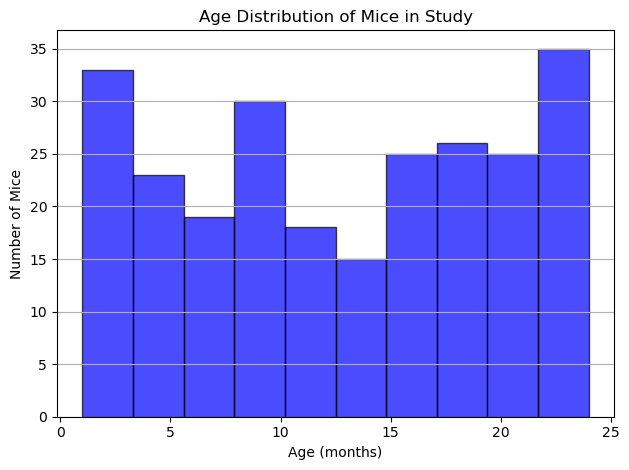

In [48]:
# Create a histogram of the age distribution of the mice in the study using the mouse_metadata DataFrame
plt.hist(mouse_metadata["Age_months"], bins=10, color="blue", alpha=0.7, edgecolor="black")
plt.title("Age Distribution of Mice in Study")
plt.xlabel("Age (months)")
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

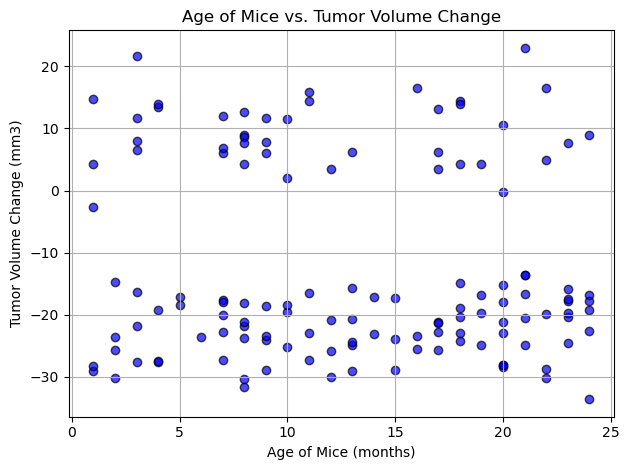

In [49]:
# Determine if there is a coorelation between the age of the mice and the tumor total volume change
# Create a scatter plot of the age of the mice and the tumor total volume change using the csdc_tumor_volume_change DataFrame at the last Timepoint
last_timepoint = csdc_tumor_volume_change[csdc_tumor_volume_change["Timepoint"] == 45]
plt.scatter(last_timepoint["Age_months"], last_timepoint["Tumor Volume (mm3) Change"], color="blue", alpha=0.7, edgecolor="black")
plt.title("Age of Mice vs. Tumor Volume Change")
plt.xlabel("Age of Mice (months)")
plt.ylabel("Tumor Volume Change (mm3)")
plt.grid()
plt.tight_layout()
plt.show()

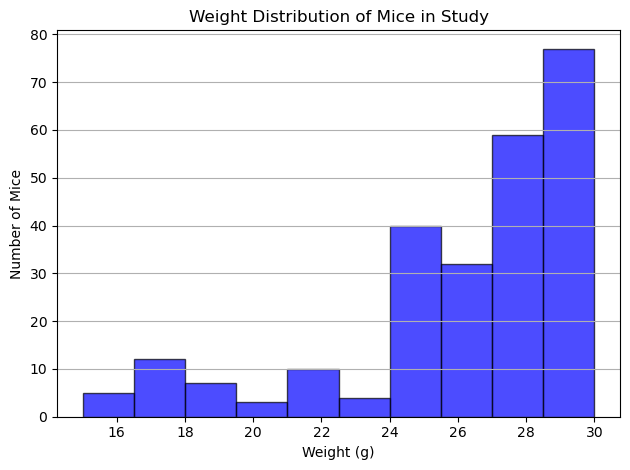

In [50]:
# Create a histogram of the weight distribution of the mice in the study using the mouse_metadata DataFrame
plt.hist(mouse_metadata["Weight (g)"], bins=10, color="blue", alpha=0.7, edgecolor="black")
plt.title("Weight Distribution of Mice in Study")
plt.xlabel("Weight (g)")
plt.ylabel("Number of Mice")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

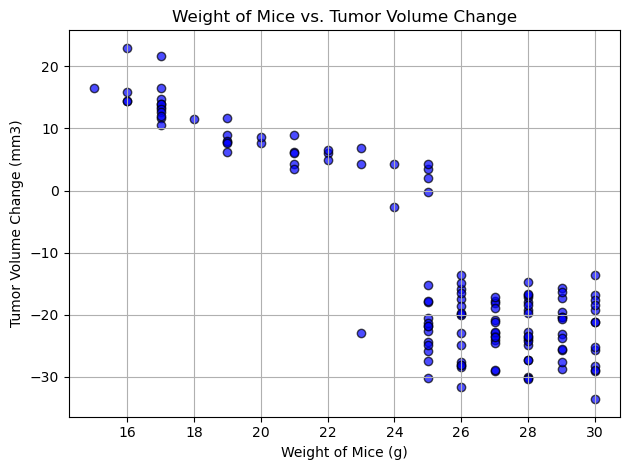

In [51]:
# Create a scatter plot of the weight of the mice and the tumor total volume change using the csdc_tumor_volume_change DataFrame at the last Timepoint
plt.scatter(last_timepoint["Weight (g)"], last_timepoint["Tumor Volume (mm3) Change"], color="blue", alpha=0.7, edgecolor="black")
plt.title("Weight of Mice vs. Tumor Volume Change")
plt.xlabel("Weight of Mice (g)")
plt.ylabel("Tumor Volume Change (mm3)")
plt.grid()
plt.tight_layout()
plt.show()

In [52]:
# List unique Drug Regimen values in the capomulin_study_data_clean DataFrame
drug_regimens = capomulin_study_data_clean["Drug Regimen"].unique()
print(drug_regimens)

['Ramicane' 'Capomulin' 'Infubinol' 'Placebo' 'Ceftamin' 'Stelasyn'
 'Zoniferol' 'Ketapril' 'Propriva' 'Naftisol']


In [53]:
# Using the last_timepoint DataFrame, separate the data into DataFrames for each Drug Regimen
ramicane_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ramicane"]
capomulin_data = last_timepoint[last_timepoint["Drug Regimen"] == "Capomulin"]
infubinol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Infubinol"]
placebo_data = last_timepoint[last_timepoint["Drug Regimen"] == "Placebo"]
ceftamin_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ceftamin"]
stelasyn_data = last_timepoint[last_timepoint["Drug Regimen"] == "Stelasyn"]
zoniferol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Zoniferol"]
ketapril_data = last_timepoint[last_timepoint["Drug Regimen"] == "Ketapril"]
propriva_data = last_timepoint[last_timepoint["Drug Regimen"] == "Propriva"]
naftisol_data = last_timepoint[last_timepoint["Drug Regimen"] == "Naftisol"] 

In [54]:
# Create a DataFrame to hold age statistical analysis for each Drug Regimen: mean, median, variance, standard deviation, and SEM
drug_regimen_age_stats = pd.DataFrame(columns=["Drug Regimen", "Mean Age (months)", "Median Age (months)", "Age Variance", "Age Standard Deviation", "Age SEM"])
print(drug_regimen_age_stats)

Empty DataFrame
Columns: [Drug Regimen, Mean Age (months), Median Age (months), Age Variance, Age Standard Deviation, Age SEM]
Index: []


In [58]:
age_stats_list = []

for drug in drug_regimens:
    drug_data = last_timepoint[last_timepoint["Drug Regimen"] == drug]
    mean_age = drug_data["Age_months"].mean()
    median_age = drug_data["Age_months"].median()
    age_variance = drug_data["Age_months"].var()
    age_std_dev = drug_data["Age_months"].std()
    age_sem = drug_data["Age_months"].sem()

    # Append the dictionary to the list
    age_stats_list.append({
        "Drug Regimen": drug, 
        "Mean Age (months)": mean_age, 
        "Median Age (months)": median_age, 
        "Age Variance": age_variance, 
        "Age Standard Deviation": age_std_dev, 
        "Age SEM": age_sem
    })

# Convert the list of dictionaries to a DataFrame
drug_regimen_age_stats = pd.DataFrame(age_stats_list)

# Display the DataFrame
drug_regimen_age_stats

,Drug Regimen,Mean Age (months),Median Age (months),Age Variance,Age Standard Deviation,Age SEM
0,Ramicane,10.050000,9.0,30.997368,5.567528,1.244937
1,Capomulin,12.809524,16.0,62.561905,7.909608,1.726018
2,Infubinol,18.555556,20.0,31.277778,5.592654,1.864218
3,Placebo,11.818182,12.0,43.563636,6.600275,1.990058
4,Ceftamin,13.538462,15.0,70.269231,8.382674,2.324936
5,Stelasyn,12.727273,13.0,86.418182,9.296138,2.802891
6,Zoniferol,13.071429,13.5,34.225275,5.850237,1.563542
7,Ketapril,16.272727,18.0,27.618182,5.255300,1.584533
8,Propriva,12.142857,10.0,56.476190,7.515064,2.840427
9,Naftisol,12.230769,9.0,40.525641,6.365975,1.765604


In [59]:
# Create a DataFrame to hold weight statistical analysis for each Drug Regimen: mean, median, variance, standard deviation, and SEM
drug_regimen_weight_stats = pd.DataFrame(columns=["Drug Regimen", "Mean Weight (g)", "Median Weight (g)", "Weight Variance", "Weight Standard Deviation", "Weight SEM"])
print(drug_regimen_weight_stats)

Empty DataFrame
Columns: [Drug Regimen, Mean Weight (g), Median Weight (g), Weight Variance, Weight Standard Deviation, Weight SEM]
Index: []


In [60]:
weight_stats_list = []

for drug in drug_regimens:
    drug_data = last_timepoint[last_timepoint["Drug Regimen"] == drug]
    mean_weight = drug_data["Weight (g)"].mean()
    median_weight = drug_data["Weight (g)"].median()
    weight_variance = drug_data["Weight (g)"].var()
    weight_std_dev = drug_data["Weight (g)"].std()
    weight_sem = drug_data["Weight (g)"].sem()

    # Append the dictionary to the list
    weight_stats_list.append({
        "Drug Regimen": drug, 
        "Mean Weight (g)": mean_weight, 
        "Median Weight (g)": median_weight, 
        "Weight Variance": weight_variance, 
        "Weight Standard Deviation": weight_std_dev, 
        "Weight SEM": weight_sem
    })

# Convert the list of dictionaries to a DataFrame
drug_regimen_weight_stats = pd.DataFrame(weight_stats_list)

# Display the DataFrame
drug_regimen_weight_stats

,Drug Regimen,Mean Weight (g),Median Weight (g),Weight Variance,Weight Standard Deviation,Weight SEM
0,Ramicane,19.300000,18.5,10.642105,3.262224,0.729455
1,Capomulin,19.857143,20.0,7.628571,2.761987,0.602715
2,Infubinol,26.666667,26.0,5.500000,2.345208,0.781736
3,Placebo,27.727273,27.0,3.218182,1.793929,0.540890
4,Ceftamin,27.615385,28.0,2.423077,1.556624,0.431730
5,Stelasyn,27.545455,28.0,2.872727,1.694912,0.511035
6,Zoniferol,27.571429,28.0,1.956044,1.398586,0.373788
7,Ketapril,27.727273,28.0,3.218182,1.793929,0.540890
8,Propriva,27.142857,26.0,3.476190,1.864454,0.704698
9,Naftisol,27.153846,27.0,2.807692,1.675617,0.464733


In [61]:
# Save the drug_regimen_age_stats DataFrame to a new CSV file
drug_regimen_age_stats_path = os.path.join("cleaned_data", "drug_regimen_age_stats.csv")
drug_regimen_age_stats.to_csv(drug_regimen_age_stats_path, index=False)
print(f"Drug Regimen Age Stats saved to {drug_regimen_age_stats_path}")

Drug Regimen Age Stats saved to cleaned_data\drug_regimen_age_stats.csv


In [62]:
# Save the drug_regimen_weight_stats DataFrame to a new CSV file
drug_regimen_weight_stats_path = os.path.join("cleaned_data", "drug_regimen_weight_stats.csv")
drug_regimen_weight_stats.to_csv(drug_regimen_weight_stats_path, index=False)
print(f"Drug Regimen Weight Stats saved to {drug_regimen_weight_stats_path}")

Drug Regimen Weight Stats saved to cleaned_data\drug_regimen_weight_stats.csv


In [63]:
# Save last_timepoint DataFrame to a new CSV file
last_timepoint_path = os.path.join("cleaned_data", "last_timepoint.csv")
last_timepoint.to_csv(last_timepoint_path, index=False)
print(f"Last Timepoint data saved to {last_timepoint_path}")

Last Timepoint data saved to cleaned_data\last_timepoint.csv
